<a href="https://colab.research.google.com/github/urspravi/my_projects/blob/main/AutoEncoder_Dense_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Implement and evaluate a Convolutional Autoencoder (CAE) for image compression and reconstruction. You can use publicly available datasets like CIFAR-10. CelebA or any other dataset of your choice

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import random

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jessicali9530/celeba-dataset

100% 1.33G/1.33G [01:07<00:00, 23.4MB/s]
100% 1.33G/1.33G [01:08<00:00, 21.0MB/s]


In [ ]:
! unzip celeba-dataset.zip

In [ ]:
df_partition = pd.read_csv('/content/list_eval_partition.csv')
img_dir = '/content/img_align_celeba/img_align_celeba/'
train_paths = [img_dir + i for i in df_partition[df_partition['partition'] == 0]['image_id']]
val_paths = [img_dir + i for i in df_partition[df_partition['partition'] == 1]['image_id']]
test_paths = [img_dir + i for i in df_partition[df_partition['partition'] == 2]['image_id']]
print(f'Train: {len(train_paths)}')
print(f'Val: {len(val_paths)}')
print(f'Test: {len(test_paths)}')

Train: 162770
Val: 19867
Test: 19962


In [ ]:
df_partition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   image_id   202599 non-null  object
 1   partition  202599 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [ ]:
df_partition

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,2
202595,202596.jpg,2
202596,202597.jpg,2
202597,202598.jpg,2


In [ ]:
def load_image(path, max_dim=None, gray=False):
    img = Image.open(path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    if gray:
        img = img.convert('L')
    return np.array(img)

def normalize(img):
    img = img / 255
    return img

def denormalize(img):
    img = img * 255
    return img

def show(img, gray=False):
    plt.axis('off')
    if gray:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)

In [ ]:
max_dim = 88
gray = False

Shape: (88, 72, 3)


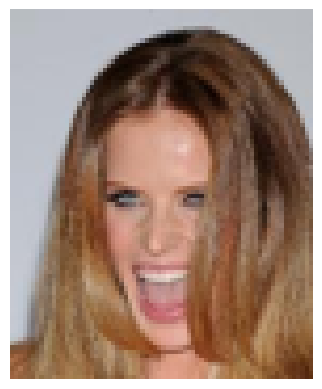

In [ ]:

im = load_image(train_paths[100031], max_dim=max_dim, gray=gray)
image_shape = im.shape
print(f'Shape: {image_shape}')
show(im, gray)

In [ ]:
train_images = np.array([load_image(path, max_dim=max_dim, gray=gray)
                         for path in train_paths[:5000]])
train_images = normalize(train_images)
train_images.shape

(5000, 88, 72, 3)

In [ ]:
test_images = np.array([load_image(path, max_dim=max_dim, gray=gray)
                         for path in test_paths[: 1000]])
test_images = normalize(test_images)
test_images.shape

(1000, 88, 72, 3)

AUTO ENCODER

In [ ]:
class Autoencoder(Model):
    def __init__(self, encoded_dim):
        super(Autoencoder, self).__init__()
        self.encoded_dim = encoded_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(encoded_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(np.prod(image_shape), activation='sigmoid'),
            layers.Reshape(image_shape)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(np.prod(image_shape) // 8)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(train_images, train_images,
                epochs=10,
                shuffle=True,
                validation_data=(test_images, test_images))

Epoch 1/10
157/157 [==============================] - 12s 37ms/step - loss: 0.0413 - val_loss: 0.0293
Epoch 2/10
157/157 [==============================] - 5s 30ms/step - loss: 0.0264 - val_loss: 0.0303
Epoch 3/10
157/157 [==============================] - 5s 29ms/step - loss: 0.0233 - val_loss: 0.0232
Epoch 4/10
157/157 [==============================] - 5s 31ms/step - loss: 0.0206 - val_loss: 0.0203
Epoch 5/10
157/157 [==============================] - 5s 30ms/step - loss: 0.0195 - val_loss: 0.0200
Epoch 6/10
157/157 [==============================] - 5s 29ms/step - loss: 0.0187 - val_loss: 0.0192
Epoch 7/10
157/157 [==============================] - 5s 31ms/step - loss: 0.0177 - val_loss: 0.0190
Epoch 8/10
157/157 [==============================] - 5s 29ms/step - loss: 0.0173 - val_loss: 0.0174
Epoch 9/10
157/157 [==============================] - 5s 30ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 10/10
157/157 [==============================] - 5s 31ms/step - loss: 0.0164 - val_l

In [ ]:
encoded_imgs = autoencoder.encoder(test_images).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

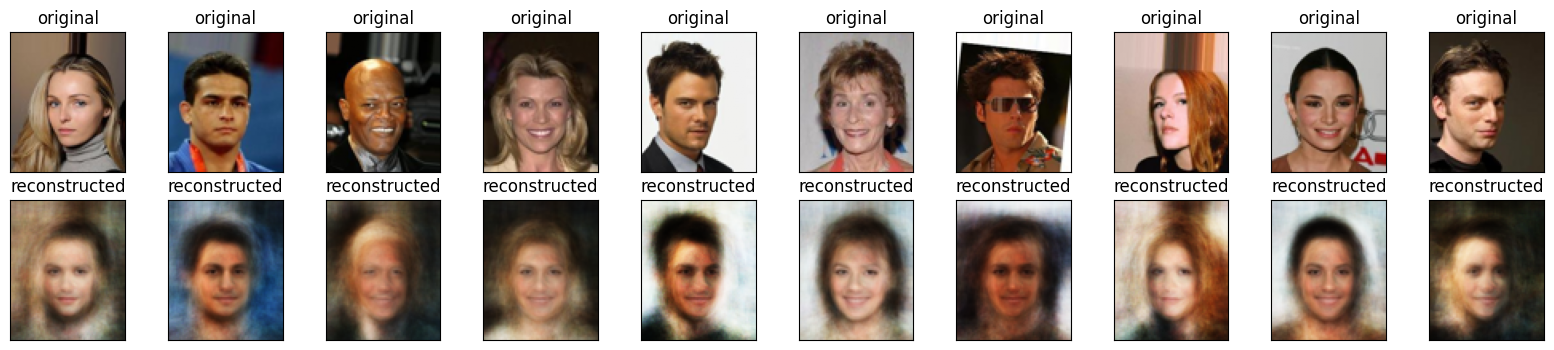

In [ ]:
n = 10
rand = random.randint(0, len(test_images) - n)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i + rand])
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i + rand])
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()